# Wildfire

In [13]:
import os, sys
import rasterio
from osgeo import gdal
from matplotlib import pyplot

In [22]:
work_dir = "./data/"
image = os.path.join(work_dir, "LWIR_QuickMosaic_16-bit_9327.tiff")

In [23]:
dataset = rasterio.open(image)

In [24]:
print(f'Name of image: {dataset.name}')
print(f'Mode of image: {dataset.mode}')
print(f'Width of image: {dataset.width}')
print(f'Height of image: {dataset.height}')
print(f'Bounding Box of image: {dataset.bounds}')
print(f'CRS of image: {dataset.crs}')
print(f'Indexes of image: {dataset.indexes}')

Name of image: ./data/LWIR_QuickMosaic_16-bit_9327.tiff
Mode of image: r
Width of image: 5184
Height of image: 12800
Bounding Box of image: BoundingBox(left=-122.446287, bottom=41.39167100000001, right=-122.35966, top=41.553101000000005)
CRS of image: EPSG:4326
Indexes of image: (1,)


In [25]:
band1 = dataset.read(1)
band1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

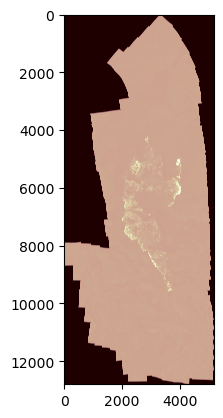

In [26]:
pyplot.imshow(band1, cmap='pink')
pyplot.show()